In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "Mutki@1215",
                             database = "ecommerce")

cur = db.cursor()
                            

# List all unique cities where customers are located.

In [5]:
query = """ select distinct customer_city from customers"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


#  Count the number of orders placed in 2017

In [6]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""
cur.execute(query)
data = cur.fetchall()
"total order placed in 2017 are", data[0][0]

('total order placed in 2017 are', 90202)

# Find the total sales per category

In [17]:
query = """ select upper(products.product_category) category, 
round(sum(payments.payment_value),2)
from order_items 
join products
on order_items.product_id = products.product_id
join payments
on order_items.order_id = payments.order_id
group by category"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["category", "Sales"])
df.head(10)

,category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
5,COMPUTER ACCESSORIES,1585330.45
6,HOUSEWARES,1094758.13
7,BABIES,539845.66
8,TOYS,619037.69
9,FURNITURE OFFICE,646826.49


# Calculate the percentage of orders that were paid in installments.

In [8]:
query = """ select sum(case when payment_installments >= 1 then 1 else 0 end)/count(order_id)*100 percentage_installments
from payments
"""
cur.execute(query)
data = cur.fetchall()
"the percentage of orders that were paid in installments", data[0][0]

('the percentage of orders that were paid in installments', Decimal('99.9981'))

# Count the number of customers from each state

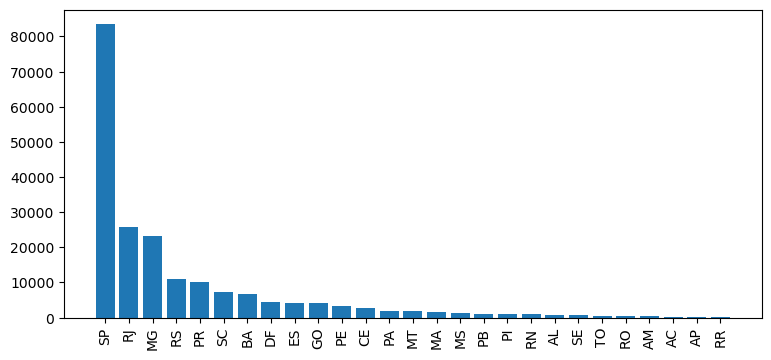

In [9]:
query = """select count(customer_id) customer_count,
customer_state
from customers
group by customer_state
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer_count", "customer_state"])
df = df.sort_values(by = "customer_count", ascending= False)
plt.figure(figsize = (9,4))
plt.bar(df["customer_state"],df["customer_count"])
plt.xticks(rotation = 90)
plt.show()

# Calculate the number of orders per month in 2018

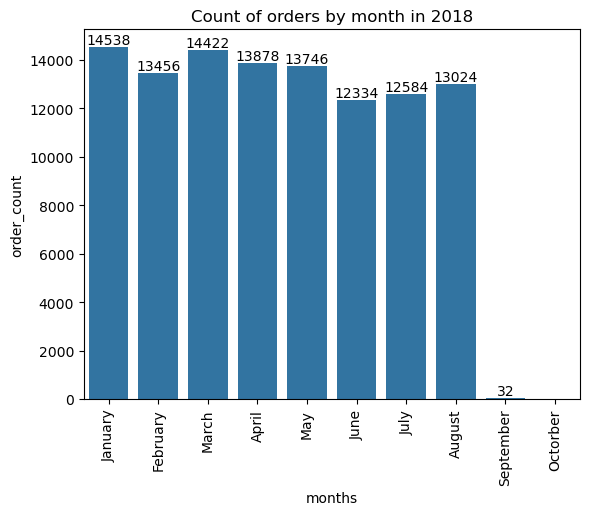

<Figure size 1000x400 with 0 Axes>

In [10]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders
where year(order_purchase_timestamp) = 2018
group by months
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January", "February", "March", "April", "May", "June", "July", "August","September", "Octorber"]
plt.xticks(rotation = 90)
ax = sns.barplot(x = df["months"],y = df["order_count"], data = df,order = o)
ax.bar_label(ax.containers[0])
plt.title("Count of orders by month in 2018")
plt.figure(figsize= (10,4))
plt.show()

#  Calculate the percentage of total revenue contributed by each product category.

In [16]:
query = """ select  product_category, round(sum(payment_value),2) Total_revenue
from order_items
join products
on order_items.product_id = products.product_id
join payments
on order_items.order_id = payments.order_id
group by product_category
order by Total_revenue desc
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["product_category", "Total_revenue"])
df.head(10)

,product_category,Total_revenue
0,bed table bath,1712553.67
1,HEALTH BEAUTY,1657373.12
2,computer accessories,1585330.45
3,Furniture Decoration,1430176.39
4,Watches present,1429216.68
5,sport leisure,1392127.56
6,housewares,1094758.13
7,automotive,852294.33
8,Garden tools,838280.75
9,Cool Stuff,779698.00


#  Find the average number of products per order, grouped by customer city.

In [13]:
query = """ with count_per_order as (
	select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
    from orders
    join order_items
    on orders.order_id = order_items.order_id
    group by orders.order_id, orders.customer_id)
select customers.customer_city, round(avg(count_per_order.oc),2) as avg_order
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer_city", "Avg_order"])
df.head(10)

,customer_city,Avg_order
0,treze tilias,2.55
1,indaial,2.23
2,sao jose dos campos,2.28
3,sao paulo,2.31
4,porto alegre,2.35
5,santos,2.32
6,sao francisco do sul,2.47
7,sao vicente,2.18
8,joinville,2.21
9,sao vendelino,2.00


# Identify the correlation between product price and the number of times a product has been purchased.

In [25]:
query = """ select products.product_category,
count(order_items.product_id) as order_times,
round(avg(order_items.price),2) as Avg_price
from products
join order_items
on products.product_id = order_items.product_id
group by products.product_category
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Product_category","times_order_placed", "Avg_price"])

arr1  = df["times_order_placed"]
arr2 = df["Avg_price"]
a = np.corrcoef([arr1,arr2])
correlation = round(a[0][1], 2)
print("The correlation between product price and the number of times a product has been purchased",correlation)

The correlation between product price and the number of times a product has been purchased -0.11


# Calculate the total revenue generated by each seller, and rank them by revenue.

In [26]:
query = """ select *, dense_rank () over(Order by Total_revenue desc) as Rank_by_revnue from
(select round(sum(payments.payment_value),2) as Total_revenue, order_items.seller_id
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Total_revenue", "seller_id", "Rank_by_revenue"])
df.head(10)

,Total_revenue,seller_id,Rank_by_revenue
0,507166.91,7c67e1448b00f6e969d365cea6b010ab,1
1,308222.04,1025f0e2d44d7041d6cf58b6550e0bfa,2
2,301245.27,4a3ca9315b744ce9f8e9374361493884,3
3,290253.42,1f50f920176fa81dab994f9023523100,4
4,284903.08,53243585a1d6dc2643021fd1853d8905,5
5,272219.32,da8622b14eb17ae2831f4ac5b9dab84a,6
6,264166.12,4869f7a5dfa277a7dca6462dcf3b52b2,7
7,236322.30,955fee9216a65b617aa5c0531780ce60,8
8,206513.23,fa1c13f2614d7b5c4749cbc52fecda94,9
9,185134.21,7e93a43ef30c4f03f38b393420bc753a,10


# Calculate the moving average of order values for each customer over their order history.

In [27]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp 
rows between 2 preceding and current row) as mov_avg from 
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer_id", "order_purchase_timestamp", "payment", "Mov_avg"])
df.head(10)

,customer_id,order_purchase_timestamp,payment,Mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
3,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
4,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
5,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
6,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
7,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
8,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
9,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


#  Calculate the cumulative sales per month for each year

In [29]:
query = """select years, months, payment, 
sum(payment) over(order by years, months) cummulative_sales 
from 
	(select year(orders.order_purchase_timestamp) as years,
	month(orders.order_purchase_timestamp) as months,
	round(sum(payments.payment_value),2) as payment
	from orders join payments
	on orders.order_id = payments.order_id
	group by years, months
	order by years, months) as a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["year", "month", "payment_sum", "cummulative_sales"])
df.head(20)

,year,month,payment_sum,cummulative_sales
0,2016,9,504.48,504.48
1,2016,10,118180.96,118685.44
2,2016,12,39.24,118724.68
3,2017,1,276976.08,395700.76
4,2017,2,583816.02,979516.78
5,2017,3,899727.20,1879243.98
6,2017,4,835576.06,2714820.04
7,2017,5,1185837.64,3900657.68
8,2017,6,1022552.76,4923210.44
9,2017,7,1184765.84,6107976.28


# Calculate the year-over-year growth rate of total sales.

In [33]:
query = """with a as (select year(orders.order_purchase_timestamp) as years,
	round(sum(payments.payment_value),2) as payment
	from orders join payments
	on orders.order_id = payments.order_id
	group by years order by years)
select years, round((payment/lag(payment, 1) over(order by years)-1)*100,2) as Year_over_Year_Growth
from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Year", "YOY_Growth"])
df

,Year,YOY_Growth
0,2016,NaN
1,2017,12112.7
2,2018,20.0


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [34]:
query = """with a as (select customers.customer_id, min(orders.order_purchase_timestamp) as first_order
from orders join customers
on orders.customer_id = customers.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) as next_order
from a join orders
on a.customer_id = orders.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < date_add(first_order, interval 6 month)
group by a.customer_id)

select 100*(count(distinct a.customer_id)/count(distinct b.customer_id))
from a left join b
on a.customer_id = b.customer_id"""

cur.execute(query)
data = cur.fetchall()
data

[(None,)]

# Identify the top 3 customers who spent the most money in each year

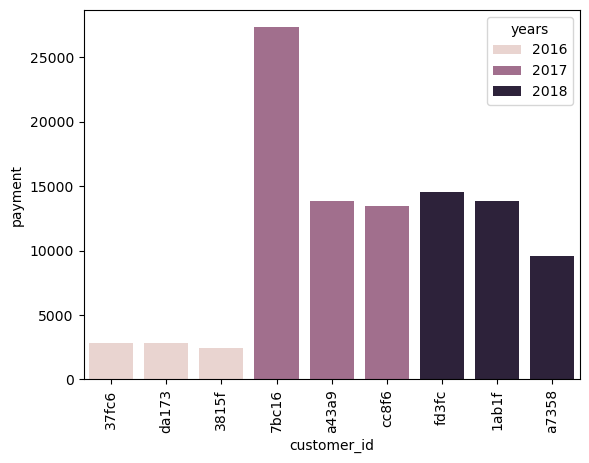

In [40]:
query = """select years, right(customer_id, 5) as id, payment, d_rank from (
	select year(orders.order_purchase_timestamp) years,
	orders.customer_id,
	sum(payments.payment_value) payment,
	dense_rank() over(partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value) desc) d_rank
	from orders join payments
	on orders.order_id = payments.order_id
	group by  year(orders.order_purchase_timestamp),
	orders.customer_id
) as a 
where d_rank <= 3"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","customer_id","payment", "Top_rank"])
sns.barplot(x = "customer_id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()